In [1]:
import numpy as np
import pandas as pd
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
from sklearn.preprocessing import MinMaxScaler
import torch

def normalise(columns):
    for column in columns:
        column_to_scale = cleaned[column].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column_to_scale)
        cleaned[column] = scaled_column.flatten()

def normalise_negative(columns):
    for column in columns:
        max_abs = np.max(np.abs(cleaned[column]))
        cleaned[column] = cleaned[column] / max_abs
        print(column, max_abs)
        
def log_smoothen(columns):
    for column in columns:
        b = gaussian(12, 6)
        cleaned[column] = convolve1d(cleaned[column], b/b.sum())
        cleaned[column] = cleaned[column].pct_change()#np.log(cleaned[column] / cleaned[column].shift(1))
    
def std_return(columns):
    for column in columns:
        cleaned[column] = (cleaned[column]-cleaned[column].shift(1)) / cleaned[column].shift(1)
        
def de_inflate(columns):
    for column in columns:
        cleaned[column] = cleaned[column]/cleaned['CPI']
        
def remove_outliers(columns):
    for column in columns:
        Q1 = cleaned[column].quantile(0.10)
        Q3 = cleaned[column].quantile(0.90)
        IQR = Q3 - Q1

        # Define bounds for identifying outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = cleaned[(cleaned[column] < lower_bound) | (cleaned[column] > upper_bound)]
        print(column, "outliers", outliers)

        # Remove outliers
        df_clean = cleaned[(cleaned[column] >= lower_bound) & (cleaned[column] <= upper_bound)]

        

In [2]:
cleaned = pd.read_excel('decorrelated.xlsx')
features = ['Open', 'Close','SPX','DXY','CPI','Fed Rate']

de_inflate(['Open', 'Close', 'SPX'])
# remove_outliers(['SPDR'])
log_smoothen(['Open', 'Close'])
normalise(['t'])
normalise_negative(['Fed Rate', 'SPX','DXY','Open', 'Close', 'CPI_pct'])

cleaned = cleaned.iloc[1:]
print(cleaned)

for feature in features:
    mean = np.mean(cleaned[feature])
    m1 = np.min(cleaned[feature])
    m2 = np.max(cleaned[feature])
    print(feature, f"{mean:.2f}", f"\t{m1:.3f}", f"\t{m2:.3f}")

Fed Rate 16.17
SPX 11.689387977557187
DXY 120.760002
Open 0.02161737872300118
Close 0.021820163091152756
CPI_pct 2.393132951313404
      Unnamed: 0.1  Unnamed: 0       Date  Fed Rate     Close      CPI  \
1                1        1626 1986-05-16  0.420532  0.021749  110.500   
2                2        1627 1986-05-19  0.426098  0.017996  110.500   
3                3        1628 1986-05-20  0.424242  0.008590  110.500   
4                4        1629 1986-05-21  0.430427 -0.008190  110.500   
5                5        1630 1986-05-22  0.424861 -0.006785  110.500   
...            ...         ...        ...       ...       ...      ...   
8480          8480       10105 2018-12-26  0.148423  0.118538  251.233   
8481          8481       10106 2018-12-27  0.148423  0.102279  251.233   
8482          8482       10107 2018-12-28  0.148423  0.094706  251.233   
8483          8483       10108 2018-12-31  0.148423  0.030821  251.233   
8484          8484       10109 2019-01-01  0.148423  0.

In [3]:
torch.save(cleaned, open('cleaned.pt', 'wb'))

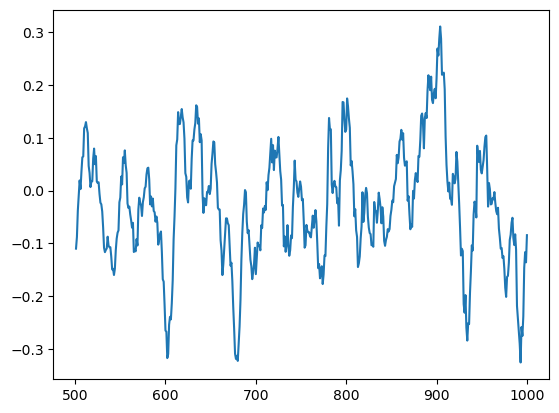

In [4]:
import matplotlib.pyplot as plt
plt.plot(cleaned['Open'][500:1000], label='SPDR')